## FA API - GraphQL

This example shows you how to call the GraphQL API and visualize the output.

In [1]:
#environment url - REPLACE <instance> example: 'myEnvironment.fasolutions.com'
instance = "<instance>"
#secret given by FA - REPLACE <secret>
secret = "<secret>"

In [2]:
#Get the access token, used to authenticate the grapqhl request
get_token_options = {
    "data":{"client_id":"fa-api","client_secret":secret,"grant_type":"client_credentials"},
    "url": f'https://{instance}/auth/realms/fa/protocol/openid-connect/token'
}

In [3]:
#TOKEN CALL
import requests

#Generic function to make a post request
def post_request(options):
  request = requests.post(options.get("url"), data=options.get("data"), json=options.get("json"), headers=options.get("headers"))
  if request.status_code == 200:
      response = request.json()
      return response
  else:
      raise Exception(f'Failed to make request, error {request.status_code}.')

token = post_request(get_token_options).get("access_token")

In [4]:
#SELECT PORTFOLIO ID
portfolioId = 7

In [5]:
#GET THE RAW DATA
query = """query  {
    portfoliosByIds(ids: [%s] ) {
    id
    name
     graph:analytics(withoutPositionData:true,
      parameters: {
        paramsSet: {
          timePeriodCodes:"GIVEN"
          includeData:true
          drilldownEnabled:false
          limit: 0
        },
        includeDrilldownPositions:false
      }) {
      dailyValues:grouppedAnalytics(key:"1") {
        dailyValue:indexedReturnData {
          date
          portfolioIndex:indexedValue
          benchmarkIndex:benchmarkIndexedValue
        }
      }
    }
  }
}""" % (portfolioId)

url = f'https://{instance}/graphql' 
headers = {'Authorization': 'Bearer %s' % token}
response = requests.post(url,headers=headers, json={'query': query})

In [6]:
#TRANSFORM THE DATA
import pandas as pd
import numpy as np
df = pd.DataFrame(response.json()['data']['portfoliosByIds'][0]["graph"]['dailyValues'])
df.head()

#GET 
df2 = pd.DataFrame([x for x in df['dailyValue']])
df2["date"] = pd.core.tools.datetimes.to_datetime(df2["date"])
df2.head()

date  portfolioIndex  benchmarkIndex
0 2021-07-27      100.000000      100.000000
1 2021-07-28       99.811473       99.546536
2 2021-07-29       99.958940       99.838668
3 2021-07-30       99.701517       99.112365
4 2021-07-31       99.705682       99.112365

<AxesSubplot:xlabel='date', ylabel='portfolioIndex'>

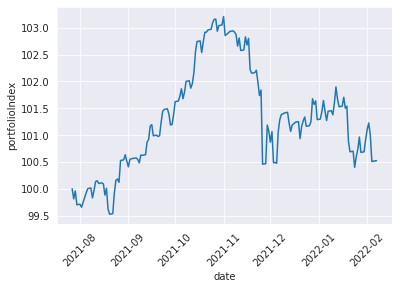

In [7]:
#PLOT DATA
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.xticks(rotation=45)
sns.lineplot(data=df2, x='date', y='portfolioIndex')